In [ ]:
%load_ext autoreload
%autoreload 2

# Deployment

> Putting a model into Deployment

In [ ]:
#| default_exp deployment

## Initial Checks 

In [ ]:
#|eval: false
!conda list | grep "pytorch"

ffmpeg                    4.3                  hf484d3e_0    pytorch
pytorch                   2.0.1           py3.11_cuda11.8_cudnn8.7.0_0    pytorch
pytorch-cuda              11.8                 h7e8668a_5    pytorch
pytorch-ignite            0.4.12                   pypi_0    pypi
pytorch-lightning         2.0.6                    pypi_0    pypi
pytorch-mutex             1.0                        cuda    pytorch
torchaudio                2.0.2               py311_cu118    pytorch
torchtriton               2.0.0                     py311    pytorch
torchvision               0.15.2              py311_cu118    pytorch


In [ ]:
#|eval: false
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [ ]:
#|eval: false
!pip list | grep "fastai" 
!pip list | grep "fastbook"
!pip list | grep "ipywidgets"

fastai                    2.7.12
fastbook                  0.0.29
ipywidgets                8.1.0


In [ ]:
#|eval: false
import torch

In [ ]:
#|eval: false
torch.cuda.is_available()

True

## Gather Data

In [ ]:
#|eval: false
from fastbook import search_images_ddg
from fastdownload import download_url
from fastai.vision.all import *
from fastAIcourse.functions import *
import os

Image file exists.


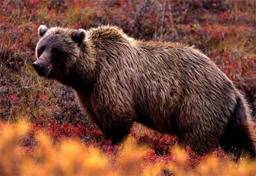

In [ ]:
#|eval: false
dest = 'grizzly'
download_pic(dest)

In [ ]:
#|code-fold: true
#|eval: false
searches = ('grizzly bears','black bears','teddy bears')
path = Path('bears')

create_data_folder(path, searches)

Folder already exists: bears


## Data Augmentation and Designing model

In [ ]:
#|eval: false
?DataBlock

Init signature:
DataBlock(
    blocks: 'list' = None,
    dl_type: 'TfmdDL' = None,
    getters: 'list' = None,
    n_inp: 'int' = None,
    item_tfms: 'list' = None,
    batch_tfms: 'list' = None,
    *,
    get_items=None,
    splitter=None,
    get_y=None,
    get_x=None,
)
Docstring:      Generic container to quickly build `Datasets` and `DataLoaders`.
File:           ~/mambaforge/envs/asdf/lib/python3.11/site-packages/fastai/data/block.py
Type:           type
Subclasses:     

In [ ]:
#|eval: false
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
#|eval: false
dls = bears.dataloaders(path)

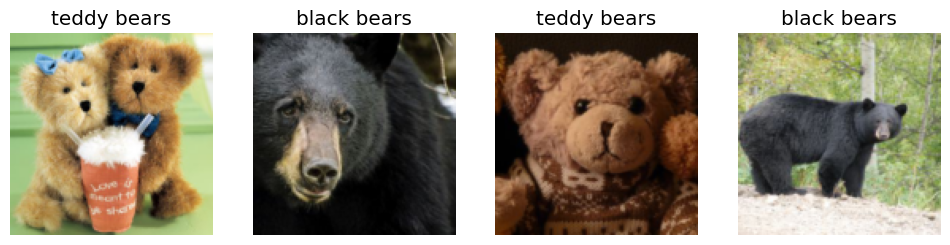

In [ ]:
#|eval: false
dls.valid.show_batch(max_n=4, nrows=1)

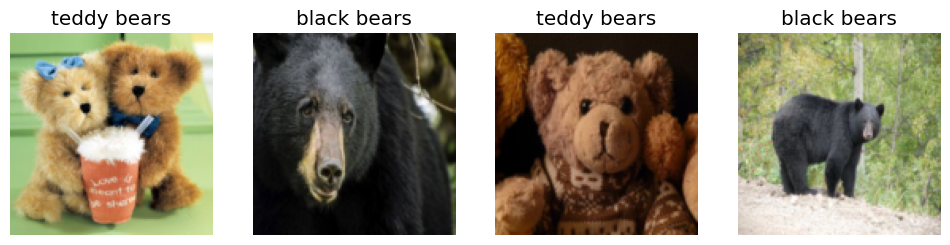

In [ ]:
#|eval: false
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

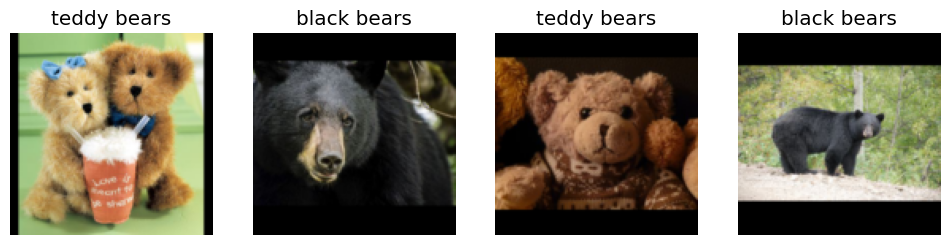

In [ ]:
#|eval: false
bears = bears.new(
    item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

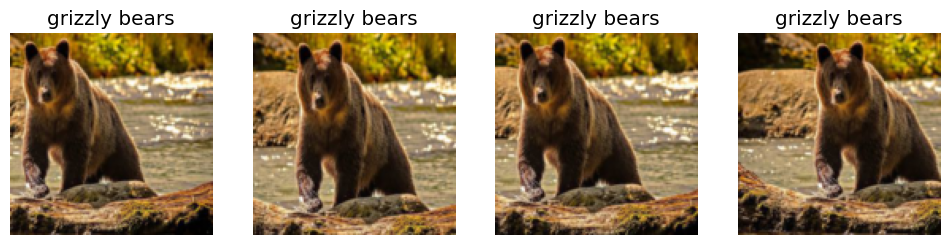

In [ ]:
#|eval: false
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Training Your Model, and Using It to Clean Your Data

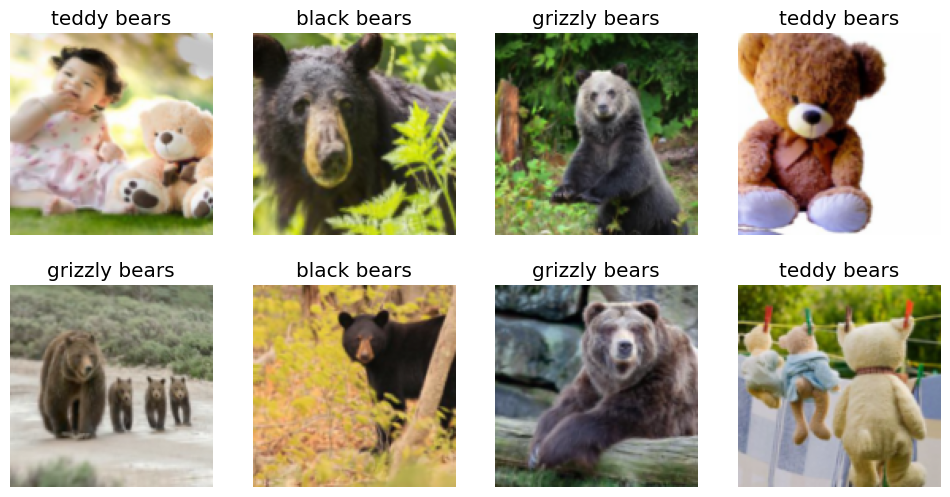

In [ ]:
#|eval: false
bears = bears.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.5),
    batch_tfms=aug_transforms(mult=1))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=False)

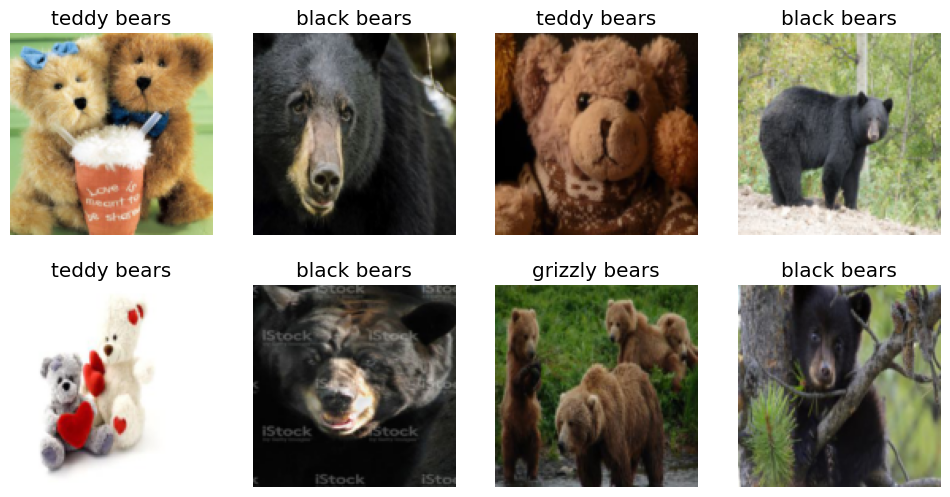

In [ ]:
#|eval: false
dls.valid.show_batch(max_n=8, nrows=2, unique=False)

## Training Your Model

In [ ]:
#|eval: false
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/home/ben/mambaforge/envs/asdf/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ben/mambaforge/envs/asdf/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.316331,0.126605,0.046729,00:03


/home/ben/mambaforge/envs/asdf/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


epoch,train_loss,valid_loss,error_rate,time
0,0.447263,0.174932,0.037383,00:02
1,0.320524,0.203087,0.028037,00:02
2,0.266786,0.186712,0.028037,00:02
3,0.229082,0.189203,0.028037,00:02
4,0.211687,0.188995,0.028037,00:02


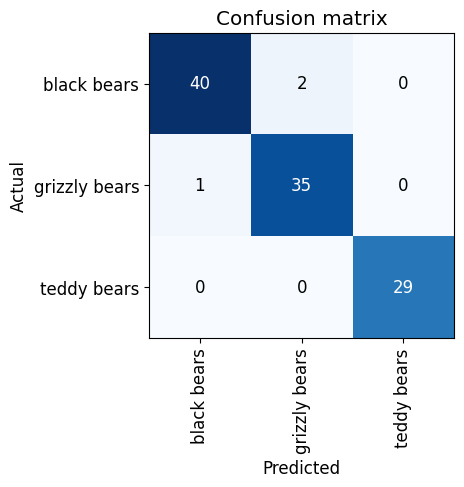

In [ ]:
#|eval: false
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

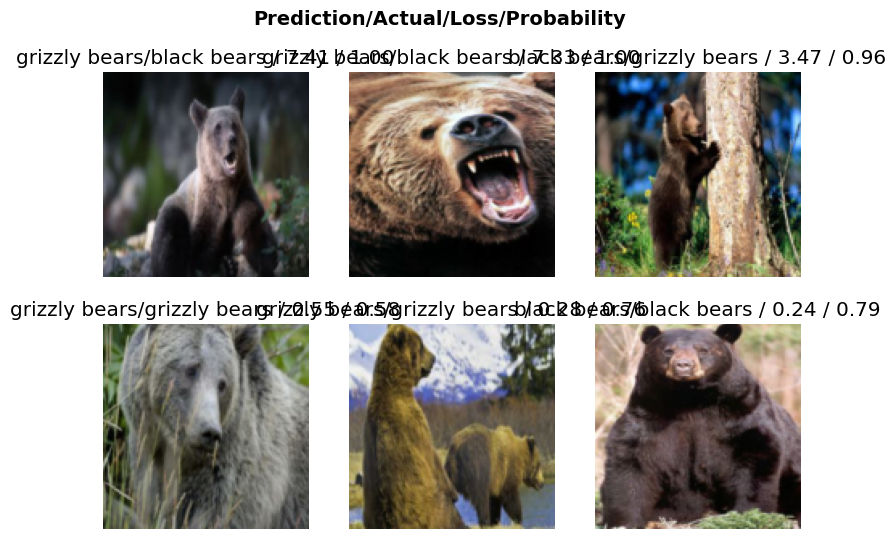

In [ ]:
#|eval: false
interp.plot_top_losses(6, nrows=2)

In [ ]:
#|eval: false
from fastai.vision.widgets import ImageClassifierCleaner

In [ ]:
#|eval: false
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Testing

Probability of grizzly bears is :0.00004.
Probability of black bears is :0.99996.
Probability of teddy bears is :0.00000.
This is a: black bears with probability: 0.99996.


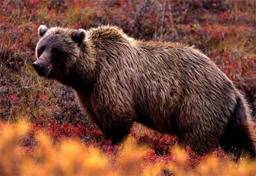

In [ ]:
#|eval: false
searches = ('grizzly bears','black bears','teddy bears')
image= 'grizzly0.jpg'


is_real,_,probs = learn.predict(PILImage.create(image))

for index, value in enumerate(searches):
    np.set_printoptions(suppress=True, precision=4)
    print(f"Probability of {value} is :{probs[index]:.5f}.")
    
max_value, max_index = torch.max(probs, dim=0)
print(f"This is a: {searches[max_index]} with probability: {max_value:.5f}.")


Image.open(image).to_thumb(256,256)

## Turning Your Model into an Online Application

In [ ]:
#|eval: false
learn.export('model.pkl')

In [ ]:
#|eval: false
path = Path()
filename = path.ls(file_exts='.pkl')
filename[0].name

'model.pkl'

In [ ]:
#|eval: false
learn_inf = load_learner(path/filename[0].name)

In [ ]:
#|eval: false
%time learn_inf.predict('grizzly0.jpg')

CPU times: user 161 ms, sys: 12.4 ms, total: 173 ms
Wall time: 60.1 ms


('grizzly bears', tensor(1), tensor([3.8220e-05, 9.9996e-01, 6.9086e-07]))

In [ ]:
#|eval: false
learn_inf.dls.vocab

['black bears', 'grizzly bears', 'teddy bears']

## Making a widget application

In [ ]:
!pip list | grep 'ipywidgets'

ipywidgets                8.1.0


In [ ]:
#|eval: false
import ipywidgets as widgets

In [ ]:
#|eval: false
btn_upload = widgets.FileUpload(
    button_style='success',
    description='Upload',
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
display(btn_upload)


FileUpload(value=(), button_style='success', description='Upload')

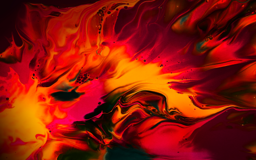

In [ ]:
#|eval: false

if btn_upload.value:
    uploaded_image = Image.open(io.BytesIO(btn_upload.value[-1].content)).to_thumb(256,256)
    display(uploaded_image)

In [ ]:
#|eval: false
out_pl = widgets.Output()
out_pl

Output()

In [ ]:
#|eval: false
if btn_upload.value:
    out_pl = widgets.Output()
    out_pl.clear_output()
    with out_pl: display(uploaded_image)
    out_pl


In [ ]:
#|eval: false
if btn_upload.value:
    uploaded_image = Image.open(io.BytesIO(btn_upload.value[-1].content)).to_thumb(256,256)
    pred,pred_idx,probs = learn_inf.predict(uploaded_image)


In [ ]:
#|eval: false
#hide_output
if btn_upload.value:
    lbl_pred = widgets.Label()
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    display(lbl_pred)


Label(value='Prediction: teddy bears; Probability: 0.9939')

In [ ]:
#|eval: false
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
#|eval: false
def on_click_classify(change):
    if btn_upload.value:
        img = Image.open(io.BytesIO(btn_upload.value[-1].content)).to_thumb(256,256)
        out_pl.clear_output()
        with out_pl: display(img)
        pred,pred_idx,probs = learn_inf.predict(img)
        lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    else:
        lbl_pred.value = f'Select image'

btn_run.on_click(on_click_classify)

In [ ]:
#|eval: false
if btn_upload.value:
    lbl_pred

In [ ]:
#|eval: false
if btn_upload.value:
    screen = widgets.VBox([widgets.Label('Select your bear!'), 
                  btn_upload,
                  btn_run,
                  out_pl, 
                  lbl_pred]
                )
    display(screen)